In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/correct-dataset-processmodel/all_data.csv
/kaggle/input/correct-all-data/all_data.csv


In [2]:
from datasets import Dataset

In [3]:
# Install necessary packages
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers=="4.40.0"
!pip install -q -U accelerate
#!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft
!pip install -q -U tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.17.0 which is incompatible.


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

# Imports

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import bitsandbytes as bnb
import torch
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.model_selection import train_test_split
#from datasets import Dataset
from peft import LoraConfig
from trl import SFTTrainer

2024-06-23 19:00:36.805306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 19:00:36.805414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 19:00:36.916475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Huggigface Authentication For Llama3 Usage

In [6]:
from huggingface_hub import HfFolder, whoami

os.environ['HUGGINGFACE_TOKEN'] = 'Need_Hugging_Face_Personal_Account_Token'
hf_token = os.getenv('HUGGINGFACE_TOKEN')

# Set the token for Hugging Face API
HfFolder.save_token(hf_token)

# Verify the authentication
user_info = whoami()
print(f"Authenticated as: {user_info['name']}")

Authenticated as: Dikshyant


In [7]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

# Disable some torch backend features for compatibility
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

working on cuda:0


# Load the dataset

In [9]:

# csv_file_path = '/kaggle/input/correction-process/process_trees_and_descriptions.csv'
csv_file_path = '/kaggle/input/correct-all-data/all_data.csv'
try:
    df = pd.read_csv(csv_file_path, on_bad_lines='skip')
    print("Data loaded successfully.")
except pd.errors.ParserError as e:
    print("Error parsing CSV file:")
    print(e)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
df

Data loaded successfully.


,Process Tree Structure,Description
0,"->( X( 'Receive_Order', +( 'Fill_Consolidation...",The initial trigger that sets off the entire p...
1,"->( 'Order_Pizza', ->( X( *( 'Cut_Toppings', '...",Every Process begins when a pizza is ordered. ...
2,"->( 'Book a meeting', ->( X( 'Prepare a presen...","Start by booking a meeting, then prepare a pre..."
3,"+( +( 'process', 'optimize' ), ->( ->( 'design...",Optimization and processing has to be done onc...
4,"*( X( 'Create_Report', ->( 'Review_Document', ...",Sometimes the organization just creates a repo...
...,...,...
86,"*( 'Prepare Order', X( 'Verify Payment', +( 'P...",This is a simple process. I start by preparing...
87,"->( *( 'accept_delivery', 'order' ), X( 'confi...","You start by accepting a delivery. Then, poten..."
88,"*( 'generate_code', ->( *( 'write_unit_test', ...","The process begins with generating code, after..."
89,"+( +( X( 'create report', +( 'generate summary...","For this process, two streams of work happen i..."


# Addition of Prompt

In [11]:
system_prompt = """
You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.
"""

# Create a dataset file in the required format for training and validation
train_df['text'] = train_df.apply(lambda row: f"{system_prompt}\n<description>\n{row['Description']}\n</description>\n<processtree>\n{row['Process Tree Structure']}\n</processtree>\n", axis=1)
val_df['text'] = val_df.apply(lambda row: f"{system_prompt}\n<description>\n{row['Description']}\n</description>\n<processtree>\n{row['Process Tree Structure']}\n</processtree>\n", axis=1)


train_df['description_with_prompting'] = train_df.apply(lambda row: f"{system_prompt}\n<description>\n{row['Description']}\n</description>\n", axis=1)
val_df['description_with_prompting'] = val_df.apply(lambda row: f"{system_prompt}\n<description>\n{row['Description']}\n</description>\n", axis=1)

In [12]:
# Add a column to mark the data as 'train' or 'val'
train_df['set'] = 'train'
val_df['set'] = 'val'

train_df
# Text: Datafield, which is given for the model to be trained on. (System Prompt + Prompt Engineering + Process Description + Process Tree Structure)
# Description_with_prompting: Process description with system prompt and  prompt engineering only.
# set, data which will be used for training or validation. 

,Process Tree Structure,Description,text,description_with_prompting,set
64,"*( ->( 'Extract Reports', +( 'Check Invoices',...","We start by extracting reports, then proceed w...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
15,"X( X( ->( 'Approve Loan Application', 'Verify ...","Our work is simple, everytime we just initiate...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
67,"*( *( 'Review Proposal', X( 'Evaluate Applicat...",We begin by reviewing a proposal. This can alr...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
77,"*( 'Package Materials', X( +( 'Process Order',...",The process starts with package materials. It ...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
30,"*( +( 'Schedule Meetings', ->( 'Send Notificat...",The main flow is that recruiter Sends Notifica...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
...,...,...,...,...,...
20,"+( ->( 'Conduct Experiment', ->( 'Analyze Resu...",Per day you will conduct one experiment for la...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
60,"X( 'Verify Information', *( +( 'Create Report'...","Either I Verify Information, after which I am ...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
71,"->( X( +( 'Pack Fresh Fruits', 'Check Inventor...",The first half of the process can take any of ...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
14,"->( *( 'Design Prototype', *( 'Develop Algorit...",The goal of this process is to enhance an exis...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train


In [13]:
train_data = Dataset.from_pandas(train_df[['text']])
val_data = Dataset.from_pandas(val_df[['text']])

In [14]:
# Save the training data to a text file
with open("train_data.txt", "w") as train_file:
    for _, row in train_df.iterrows():
        train_file.write(f"{system_prompt}\n<description>\n{row['Description']}\n</description>\n<processtree>\n{row['Process Tree Structure']}\n</processtree>\n")

# Save the validation data to a text file
with open("val_data.txt", "w") as val_file:
    for _, row in val_df.iterrows():
        val_file.write(f"{system_prompt}\n<description>\n{row['Description']}\n</description>\n<processtree>\n{row['Process Tree Structure']}\n</processtree>\n")


In [15]:
train_data = Dataset.from_pandas(train_df[['text']])
val_data = Dataset.from_pandas(val_df[['text']])

# Model Configuration

In [16]:
# Model configuration
model_name = "meta-llama/Meta-Llama-3-8B"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=512)
tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
output_dir="trained_weights"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
)

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=1,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="steps",  # Ensuring evaluation is done during training
    eval_steps=1,  
)

In [18]:

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=512,
    packing=False,
)


Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

# Helper method:
## 1. generate_process_tree : Takes input of text (process description + prompt engineering), Outputs a text by Model.
## 2. extract_process_tree : Takes the text (whole output text of the model) and extracts the ProcessTree from the given String.

In [19]:
# Function to generate process tree structure from description
def generate_process_tree(description, model, tokenizer, device):
    input_ids = tokenizer.encode(description, return_tensors='pt').to(device)
    output = model.generate(
        input_ids, 
        max_length=600, 
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_process_tree(generated_text):
    start_tag = "<processtree>"
    end_tag = "</processtree>"
    
    # Find all start tag positions
    start_indices = [i for i in range(len(generated_text)) if generated_text.startswith(start_tag, i)]
    
    # Find all end tag positions
    end_indices = [i for i in range(len(generated_text)) if generated_text.startswith(end_tag, i)]
    
    # Check if there are at least two occurrences
    if len(start_indices) < 2 or len(end_indices) < 2:
        return None  # Return None or appropriate value if there are not enough occurrences
    
    # Extract the second occurrence
    second_start_idx = start_indices[1] + len(start_tag)
    second_end_idx = end_indices[1]
    
    return generated_text[second_start_idx:second_end_idx].strip()

# All data (train + valid) for analysis of process tree generated by model before finetuning

In [20]:
# Concatenate train and validation data
all_data = pd.concat([train_df, val_df])
all_data

,Process Tree Structure,Description,text,description_with_prompting,set
64,"*( ->( 'Extract Reports', +( 'Check Invoices',...","We start by extracting reports, then proceed w...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
15,"X( X( ->( 'Approve Loan Application', 'Verify ...","Our work is simple, everytime we just initiate...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
67,"*( *( 'Review Proposal', X( 'Evaluate Applicat...",We begin by reviewing a proposal. This can alr...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
77,"*( 'Package Materials', X( +( 'Process Order',...",The process starts with package materials. It ...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
30,"*( +( 'Schedule Meetings', ->( 'Send Notificat...",The main flow is that recruiter Sends Notifica...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train
...,...,...,...,...,...
12,"X( 'analyze data', *( X( 'develop algorithm', ...",The process starts with a choice between two a...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val
4,"*( X( 'Create_Report', ->( 'Review_Document', ...",Sometimes the organization just creates a repo...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val
18,"->( X( 'Order Product', ->( X( 'Review Invoice...",Either order a product or review an invoice or...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val
28,"*( +( ->( 'Order Pizza', +( 'Get Ingredients',...","When pizza is ordered (Order Pizza), at the sa...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val


# Prediction of Process Tree without finetuning model on all datasets

In [21]:

from time import time
total_entries = len(all_data)
batch_size = 1  # Define how often you want to print the progress
count = 0

# Start the timer
start_time = time()

# Initialize an empty list to store results
results = []

for idx, row in all_data.iterrows():
    process_tree = generate_process_tree(row['description_with_prompting'], model, tokenizer, device)
    extracted_tree = extract_process_tree(process_tree)
    results.append(extracted_tree)
    
    # Update the DataFrame with the new results
    all_data.at[idx, 'Generated Process Tree- Without FineTuning'] = extracted_tree
    
    # Print progress at every batch_size interval
    if (idx + 1) % batch_size == 0 or (idx + 1) == total_entries:
        print(f"Processed {count} of {total_entries} entries.")
    count = count + 1

# End the timer
end_time = time()

# Calculate total time taken
total_time = end_time - start_time

# Display the results
print(f"Total entries: {total_entries}")
print(f"Time taken: {total_time:.2f} seconds")


Processed 0 of 91 entries.
Processed 1 of 91 entries.
Processed 2 of 91 entries.
Processed 3 of 91 entries.
Processed 4 of 91 entries.
Processed 5 of 91 entries.
Processed 6 of 91 entries.
Processed 7 of 91 entries.
Processed 8 of 91 entries.
Processed 9 of 91 entries.
Processed 10 of 91 entries.
Processed 11 of 91 entries.
Processed 12 of 91 entries.
Processed 13 of 91 entries.
Processed 14 of 91 entries.
Processed 15 of 91 entries.
Processed 16 of 91 entries.
Processed 17 of 91 entries.
Processed 18 of 91 entries.
Processed 19 of 91 entries.
Processed 20 of 91 entries.
Processed 21 of 91 entries.
Processed 22 of 91 entries.
Processed 23 of 91 entries.
Processed 24 of 91 entries.
Processed 25 of 91 entries.
Processed 26 of 91 entries.
Processed 27 of 91 entries.
Processed 28 of 91 entries.
Processed 29 of 91 entries.
Processed 30 of 91 entries.
Processed 31 of 91 entries.
Processed 32 of 91 entries.
Processed 33 of 91 entries.
Processed 34 of 91 entries.
Processed 35 of 91 entries.
Pr

In [22]:
all_data.head()

,Process Tree Structure,Description,text,description_with_prompting,set,Generated Process Tree- Without FineTuning
64,"*( ->( 'Extract Reports', +( 'Check Invoices',...","We start by extracting reports, then proceed w...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,<task>\n<task>\n<task>\n<task>\n<task>\n<task>...
15,"X( X( ->( 'Approve Loan Application', 'Verify ...","Our work is simple, everytime we just initiate...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,"<root>\n<activity name=""initiate loan applicat..."
67,"*( *( 'Review Proposal', X( 'Evaluate Applicat...",We begin by reviewing a proposal. This can alr...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,None
77,"*( 'Package Materials', X( +( 'Process Order',...",The process starts with package materials. It ...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,<task>\n <description>Package Materials...
30,"*( +( 'Schedule Meetings', ->( 'Send Notificat...",The main flow is that recruiter Sends Notifica...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,<sequence>\n<parallel>\n<sequence>\n<task>Send...


# Example of Text Given for the model to train

In [23]:
first_text_element = all_data['text'].iloc[0]
print(first_text_element)


You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
We start by extracting reports, then proceed with checking invoices while processing payments, and if we are not finished then, we need to analyze financials or generate balance sheets, before extracting reports again.
</description>
<processtree>
*( ->( 'Extract Reports', +( 'Check Invoices', 'Process Payments' ) ), X( 'Analyze Financials', 'Generate Balance Sheets' ) )
</processtree>



# Example of text used for prediction

In [24]:
first_text_element = all_data['description_with_prompting'].iloc[0]
print(first_text_element)


You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
We start by extracting reports, then proceed with checking invoices while processing payments, and if we are not finished then, we need to analyze financials or generate balance sheets, before extracting reports again.
</description>



# Example of Text generated by the model, when given a process description

In [25]:
# Example description validation
description = """
You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
During Recruitment Process, Recruiting Team needs to Prepare Proposal, drafting a comprehensive plan, and then Hire Candidate, and completes the process. Concurrently, team Conducts Interviews, gathering important information. Additional task is to Review Budget for the recuitment. This can end up when the Interviews are conducted or budget is accepted. If there are multiple positions and need to make decisions about which options are mostly relevant, then options are evaluated. Also with this case, other member needs to develop design or generate requirements about the job descriptions and all the criteria. The features are parallel finalized. When all are completed, then budget is again reviewed until all criteria is fulfilled.
</description>
"""
# +( ->( 'Prepare Proposal', 'Hire Candidate' ), X( 'Conduct Interviews', *( 'Review Budget', X( 'Evaluate Options', +( 'Finalize Features', X( 'Develop Design', 'Generate Requirements' ) ) ) ) ) )

predicted_tree = generate_process_tree(description, model, tokenizer, device)
print(predicted_tree)


You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
During Recruitment Process, Recruiting Team needs to Prepare Proposal, drafting a comprehensive plan, and then Hire Candidate, and completes the process. Concurrently, team Conducts Interviews, gathering important information. Additional task is to Review Budget for the recuitment. This can end up when the Interviews are conducted or budget is accepted. If there are multiple positions and need to make decisions about which options are mostly relevant, then options are evaluated. Also with this case, other member needs to develop design or generate requirements about the job descriptions and all the criteria. The features are parallel finalized. When all are completed, then budget is ag

In [26]:
# Example description train
description = """
You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
We start by extracting reports, then proceed with checking invoices while processing payments, and if we are not finished then, we need to analyze financials or generate balance sheets, before extracting reports again.
</description>
"""
# *( ->( 'Extract Reports', +( 'Check Invoices', 'Process Payments' ) ), X( 'Analyze Financials', 'Generate Balance Sheets' ) )

predicted_tree = generate_process_tree(description, model, tokenizer, device)
print(predicted_tree)


You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
We start by extracting reports, then proceed with checking invoices while processing payments, and if we are not finished then, we need to analyze financials or generate balance sheets, before extracting reports again.
</description>
<processtree>
<process>
<process>
<process>
<process>
<process>
</process>
</process>
</process>
</process>
</process>
</processtree>



# Training of model

In [27]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss
1,2.295000,2.452241
2,2.434200,2.401853
3,2.251300,2.288670
4,2.119700,2.090101
5,1.884700,1.897247
6,1.701400,1.749299
7,1.806500,1.643967
8,1.550000,1.567950
9,1.546700,1.534840
10,1.320400,1.513484


TrainOutput(global_step=90, training_loss=0.760373046911425, metrics={'train_runtime': 3275.517, 'train_samples_per_second': 0.22, 'train_steps_per_second': 0.027, 'total_flos': 7731776597606400.0, 'train_loss': 0.760373046911425, 'epoch': 10.0})

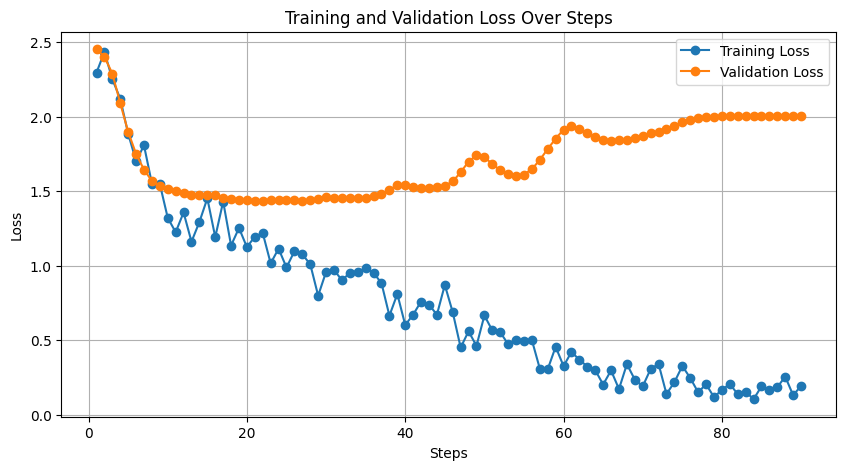

In [36]:
import matplotlib.pyplot as plt

# Extract log history from the trainer
log_history = trainer.state.log_history

# Initialize lists to store losses and steps
training_loss = []
validation_loss = []
steps = []

# Iterate through log history and extract relevant data
for log in log_history:
    if 'loss' in log:
        training_loss.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:
        validation_loss.append(log['eval_loss'])

# Ensure the lengths of losses match the steps (in case some steps don't have validation loss)
min_length = min(len(training_loss), len(validation_loss))
training_loss = training_loss[:min_length]
validation_loss = validation_loss[:min_length]
steps = steps[:min_length]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.plot(steps, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Save the model and tokenizer
model.save_pretrained("./model_finetuned_llama3-7B")
tokenizer.save_pretrained("./finetuned_llama3-7B")

('./finetuned_llama3-7B/tokenizer_config.json',
 './finetuned_llama3-7B/special_tokens_map.json',
 './finetuned_llama3-7B/tokenizer.json')

# Addition of Process Tree after finetuned model

In [29]:
# Initialize an empty list to store results
results = []
count = 0

for idx, row in all_data.iterrows():
    process_tree = generate_process_tree(row['description_with_prompting'], model, tokenizer, device)
    extracted_tree = extract_process_tree(process_tree)
    results.append(extracted_tree)
    
    # Update the DataFrame with the new results
    all_data.at[idx, 'Generated Process Tree- After FineTuning'] = extracted_tree
    
    # Print progress at every batch_size interval
    if (idx + 1) % batch_size == 0 or (idx + 1) == total_entries:
        print(f"Processed {count} of {total_entries} entries.")
    count = count + 1

Processed 0 of 91 entries.
Processed 1 of 91 entries.
Processed 2 of 91 entries.
Processed 3 of 91 entries.
Processed 4 of 91 entries.
Processed 5 of 91 entries.
Processed 6 of 91 entries.
Processed 7 of 91 entries.
Processed 8 of 91 entries.
Processed 9 of 91 entries.
Processed 10 of 91 entries.
Processed 11 of 91 entries.
Processed 12 of 91 entries.
Processed 13 of 91 entries.
Processed 14 of 91 entries.
Processed 15 of 91 entries.
Processed 16 of 91 entries.
Processed 17 of 91 entries.
Processed 18 of 91 entries.
Processed 19 of 91 entries.
Processed 20 of 91 entries.
Processed 21 of 91 entries.
Processed 22 of 91 entries.
Processed 23 of 91 entries.
Processed 24 of 91 entries.
Processed 25 of 91 entries.
Processed 26 of 91 entries.
Processed 27 of 91 entries.
Processed 28 of 91 entries.
Processed 29 of 91 entries.
Processed 30 of 91 entries.
Processed 31 of 91 entries.
Processed 32 of 91 entries.
Processed 33 of 91 entries.
Processed 34 of 91 entries.
Processed 35 of 91 entries.
Pr

In [30]:
all_data

,Process Tree Structure,Description,text,description_with_prompting,set,Generated Process Tree- Without FineTuning,Generated Process Tree- After FineTuning
64,"*( ->( 'Extract Reports', +( 'Check Invoices',...","We start by extracting reports, then proceed w...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,<task>\n<task>\n<task>\n<task>\n<task>\n<task>...,"*( ->( 'Extract Reports', +( 'Check Invoices',..."
15,"X( X( ->( 'Approve Loan Application', 'Verify ...","Our work is simple, everytime we just initiate...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,"<root>\n<activity name=""initiate loan applicat...","X( X( ->( 'Approve Loan Application', 'Verify ..."
67,"*( *( 'Review Proposal', X( 'Evaluate Applicat...",We begin by reviewing a proposal. This can alr...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,None,"*( *( 'Review Proposal', X( 'Evaluate Applicat..."
77,"*( 'Package Materials', X( +( 'Process Order',...",The process starts with package materials. It ...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,<task>\n <description>Package Materials...,"*( 'Package Materials', X( +( 'Process Order',..."
30,"*( +( 'Schedule Meetings', ->( 'Send Notificat...",The main flow is that recruiter Sends Notifica...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,train,<sequence>\n<parallel>\n<sequence>\n<task>Send...,"*( +( 'Schedule Meetings', ->( 'Send Notificat..."
...,...,...,...,...,...,...,...
12,"X( 'analyze data', *( X( 'develop algorithm', ...",The process starts with a choice between two a...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val,<node>\n <description>Analyze Data</des...,"X( 'Analyze Data', *( *( 'Design Model', 'Deve..."
4,"*( X( 'Create_Report', ->( 'Review_Document', ...",Sometimes the organization just creates a repo...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val,<task>create report</task>\n<task>review docum...,"*( X( 'Create Report', ->( 'Review Document', ..."
18,"->( X( 'Order Product', ->( X( 'Review Invoice...",Either order a product or review an invoice or...,\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val,<process>\n<task>order a product</task>\n<task...,"X( X( 'order product', X('review invoice', 'cr..."
28,"*( +( ->( 'Order Pizza', +( 'Get Ingredients',...","When pizza is ordered (Order Pizza), at the sa...",\nYou are an expert in generating process tree...,\nYou are an expert in generating process tree...,val,<process>\n<name>Order Pizza</name>\n<start/>\...,"+( *( 'Order Pizza', +( 'Get Ingredients', 'Fe..."


# Example of Process Description

In [31]:
first_text_element = all_data['description_with_prompting'].iloc[0]
print(first_text_element)


You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
We start by extracting reports, then proceed with checking invoices while processing payments, and if we are not finished then, we need to analyze financials or generate balance sheets, before extracting reports again.
</description>



# Example of Process Tree generated by finetuned model

In [32]:
predicted_tree = generate_process_tree(all_data['description_with_prompting'].iloc[0], model, tokenizer, device)
print(predicted_tree)
extract_process_tree(process_tree)


You are an expert in generating process trees from descriptions. Given a description between <description> and </description>, create a process tree in the format specified between <processtree> and </processtree>. The process tree should reflect the sequence and parallel tasks described.

<description>
We start by extracting reports, then proceed with checking invoices while processing payments, and if we are not finished then, we need to analyze financials or generate balance sheets, before extracting reports again.
</description>
<processtree>
*( ->( 'Extract Reports', +( 'Check Invoices', 'Process Payments' ) ), X( 'Analyze Financials', 'Generate Balance Sheets' ) )
</processtree>
</description>
<processtree>
*( 'Identify Customers', +( 'Analyze Sales Trends', 'Develop Marketing Strategies' ) )
</processtree>
</description>
<processtree>
*( 'Receive Order', ->( 'Process Payment', 'Verify Inventory' ) )
</processtree>
</description>
</processtree>
The process tree should reflect th

"*( *( 'Receive Order', +( 'Confirm with Customer', 'Inspect Order Details' ) ), X( 'Cancel', 'Evaluate Order' ) ), ->( +( 'Notify Customer', 'Archive Order' ), ->( 'Send Confirmation Email', 'Update Database' ) ) )"

In [33]:
# Save the results to a new CSV file
output_df = all_data[['Description', 'Process Tree Structure',  'description_with_prompting', 'Generated Process Tree- Without FineTuning', 'Generated Process Tree- After FineTuning', 'set']]
output_df.to_csv('processed_data.csv', index=False)

In [35]:
output_df

,Description,Process Tree Structure,description_with_prompting,Generated Process Tree- Without FineTuning,Generated Process Tree- After FineTuning,set
64,"We start by extracting reports, then proceed w...","*( ->( 'Extract Reports', +( 'Check Invoices',...",\nYou are an expert in generating process tree...,<task>\n<task>\n<task>\n<task>\n<task>\n<task>...,"*( ->( 'Extract Reports', +( 'Check Invoices',...",train
15,"Our work is simple, everytime we just initiate...","X( X( ->( 'Approve Loan Application', 'Verify ...",\nYou are an expert in generating process tree...,"<root>\n<activity name=""initiate loan applicat...","X( X( ->( 'Approve Loan Application', 'Verify ...",train
67,We begin by reviewing a proposal. This can alr...,"*( *( 'Review Proposal', X( 'Evaluate Applicat...",\nYou are an expert in generating process tree...,None,"*( *( 'Review Proposal', X( 'Evaluate Applicat...",train
77,The process starts with package materials. It ...,"*( 'Package Materials', X( +( 'Process Order',...",\nYou are an expert in generating process tree...,<task>\n <description>Package Materials...,"*( 'Package Materials', X( +( 'Process Order',...",train
30,The main flow is that recruiter Sends Notifica...,"*( +( 'Schedule Meetings', ->( 'Send Notificat...",\nYou are an expert in generating process tree...,<sequence>\n<parallel>\n<sequence>\n<task>Send...,"*( +( 'Schedule Meetings', ->( 'Send Notificat...",train
...,...,...,...,...,...,...
12,The process starts with a choice between two a...,"X( 'analyze data', *( X( 'develop algorithm', ...",\nYou are an expert in generating process tree...,<node>\n <description>Analyze Data</des...,"X( 'Analyze Data', *( *( 'Design Model', 'Deve...",val
4,Sometimes the organization just creates a repo...,"*( X( 'Create_Report', ->( 'Review_Document', ...",\nYou are an expert in generating process tree...,<task>create report</task>\n<task>review docum...,"*( X( 'Create Report', ->( 'Review Document', ...",val
18,Either order a product or review an invoice or...,"->( X( 'Order Product', ->( X( 'Review Invoice...",\nYou are an expert in generating process tree...,<process>\n<task>order a product</task>\n<task...,"X( X( 'order product', X('review invoice', 'cr...",val
28,"When pizza is ordered (Order Pizza), at the sa...","*( +( ->( 'Order Pizza', +( 'Get Ingredients',...",\nYou are an expert in generating process tree...,<process>\n<name>Order Pizza</name>\n<start/>\...,"+( *( 'Order Pizza', +( 'Get Ingredients', 'Fe...",val
